# House Sale Price Prediction

In [1]:
#We Begin by importing the necessary libraries.

import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor 
from collections import Counter
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.metrics import accuracy_score

%matplotlib inline

## Part 1 - Data Exploration

In [2]:
train = pd.read_csv("train.csv", low_memory=False)
test = pd.read_csv("test.csv", low_memory=False)

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
df = train
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Part 1.5 - Initial Impressions

#### Lets start by looking at Dates

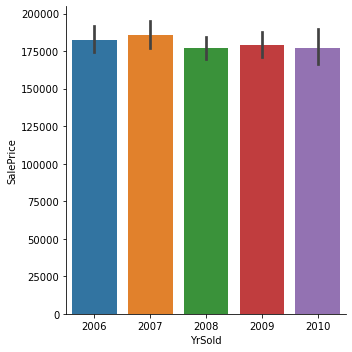

In [4]:
sns.catplot(data=train, kind="bar", x="YrSold", y="SalePrice")

The first thing to look for when you see Housing Prices during this period is how much the depression during 2008 affected prices. We can see that represented here because prices rise from 2006-2007, but fall from 2007-2008.

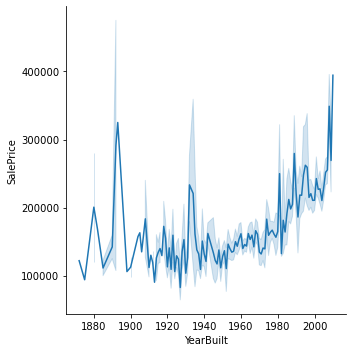

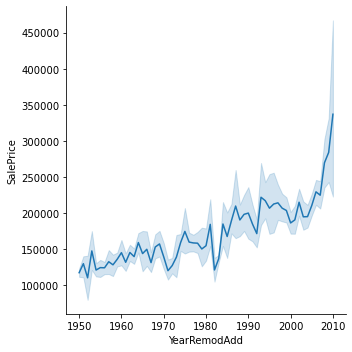

In [5]:
sns.relplot(data=train, kind="line", x="YearBuilt", y="SalePrice")
sns.relplot(data=train, kind="line", x="YearRemodAdd", y="SalePrice")

We see a few interesting trends here. Houses built during the late 1900s, as well as houses built during 1930s sell for more than those around their time. The remodel chart is much more standard and we can see that the houses that were remodeled later almost always sold for more.

#### Now lets look at Conditions of the properties

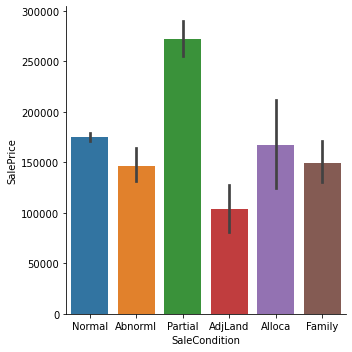

In [6]:
sns.catplot(data=train, kind="bar", x="SaleCondition", y="SalePrice")

The data continues to look normal here. Partial sales (which is listed as homes that are new) seem to sell for the most, while abnormal sales such as foreclosers sell for the lowest amount.

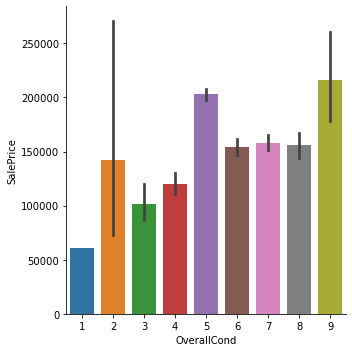

In [7]:
sns.catplot(data=train, kind="bar", x="OverallCond", y="SalePrice")

Here, we see a large amount of variation within the houses sold with a rating of 2 and 9. Lets explore further.

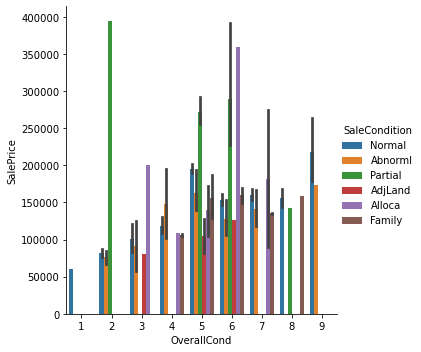

In [8]:
sns.catplot(data=train, kind="bar", x="OverallCond", y="SalePrice", hue="SaleCondition")

Now we can see that there was a house that was rated a 2, but was bought new for almost quadruple the prices of other properties that were rated at 2. The same seems to happen at 6, but its not as drastic as the property in 2. This could potential affect our models.

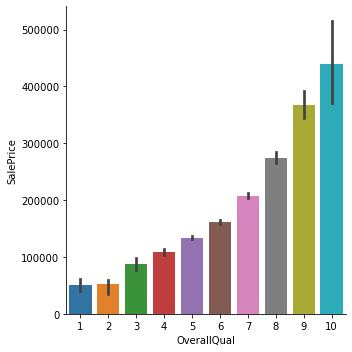

In [9]:
sns.catplot(data=train, kind="bar", x="OverallQual", y="SalePrice")

This is a great graph and could be a great feature in predicting the price of a house.

#### Now lets look at the types of properties/locations of properties that are being sold.

This should be the most important section because we would expect the type of house to be the largest factor in determining its price.

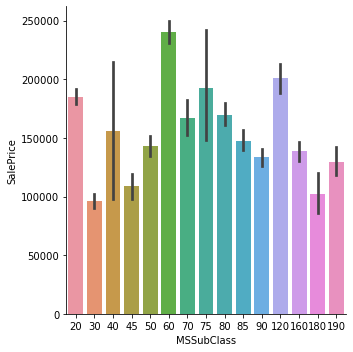

In [10]:
sns.catplot(data=train, kind="bar", x="MSSubClass", y="SalePrice")

We see that 60 is the most expensive type of dwelling that was sold. 60 identifies 2 story dwellings that were built in 1946 or later. 30 is the cheapest, and 30 is 1 story buildings that were built in 1945 or earlier.

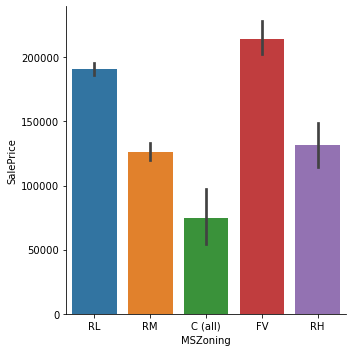

In [11]:
sns.catplot(data=train, kind="bar", x="MSZoning", y="SalePrice")

Out of the 3 R (Residential Zones), we can see that the low density residential zone (RL) was the one with the most demand. However, the area with the most expensive housing is actually the Floating Village-Residential which is a type of luxury housing. 

## Part 2 - Data Cleaning

In [12]:
df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [13]:
df.loc[df["MSZoning"] == "A", "MSZoning"] = 0 
df.loc[df["MSZoning"] == "C", "MSZoning"] = 1
df.loc[df["MSZoning"] == "FV", "MSZoning"] = 2 
df.loc[df["MSZoning"] == "I", "MSZoning"] = 3
df.loc[df["MSZoning"] == "RH", "MSZoning"] = 4
df.loc[df["MSZoning"] == "RL", "MSZoning"] = 5
df.loc[df["MSZoning"] == "RP", "MSZoning"] = 6
df.loc[df["MSZoning"] == "RM", "MSZoning"] = 7

In [14]:
df['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [15]:
df.loc[df["Street"] == "Pave", "Street"] = 0
df.loc[df["Street"] == "Grvl", "Street"] = 1

In [16]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [17]:
df.loc[df["Alley"] == "Pave", "Alley"] = 0
df.loc[df["Alley"] == "Grvl", "Alley"] = 1
df.loc[df["Alley"] == "NA", "Alley"] = 2

In [18]:
df['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [19]:
df.loc[df["LotShape"] == "Reg", "LotShape"] = 0
df.loc[df["LotShape"] == "IR1", "LotShape"] = 1
df.loc[df["LotShape"] == "IR2", "LotShape"] = 2
df.loc[df["LotShape"] == "IR3", "LotShape"] = 3

In [20]:
df['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [21]:
df.loc[df["LandContour"] == "Lvl", "LandContour"] = 0
df.loc[df["LandContour"] == "Bnk", "LandContour"] = 1
df.loc[df["LandContour"] == "HLS", "LandContour"] = 2
df.loc[df["LandContour"] == "Low", "LandContour"] = 3

In [22]:
df['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [23]:
df.loc[df["Utilities"] == "AllPub", "Utilities"] = 0
df.loc[df["Utilities"] == "NoSeWa", "Utilities"] = 1
df.loc[df["Utilities"] == "NoSewr", "Utilities"] = 2
df.loc[df["Utilities"] == "ELO", "Utilities"] = 3

In [24]:
df['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [25]:
df.loc[df["LotConfig"] == "Inside", "LotConfig"] = 0
df.loc[df["LotConfig"] == "Corner", "LotConfig"] = 1
df.loc[df["LotConfig"] == "CulDSac", "LotConfig"] = 2
df.loc[df["LotConfig"] == "FR2", "LotConfig"] = 3
df.loc[df["LotConfig"] == "FR3", "LotConfig"] = 4

In [26]:
df['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [27]:
df.loc[df["LandSlope"] == "Gtl", "LandSlope"] = 0
df.loc[df["LandSlope"] == "Mod", "LandSlope"] = 1
df.loc[df["LandSlope"] == "Sev", "LandSlope"] = 2

In [28]:
df['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [29]:
df.loc[df["Neighborhood"] == "NAmes", "Neighborhood"] = 0
df.loc[df["Neighborhood"] == "CollgCr", "Neighborhood"] = 1
df.loc[df["Neighborhood"] == "OldTown", "Neighborhood"] = 2
df.loc[df["Neighborhood"] == "Edwards", "Neighborhood"] = 3
df.loc[df["Neighborhood"] == "Somerst", "Neighborhood"] = 4
df.loc[df["Neighborhood"] == "Gilbert", "Neighborhood"] = 5
df.loc[df["Neighborhood"] == "NridgHt", "Neighborhood"] = 6
df.loc[df["Neighborhood"] == "Sawyer", "Neighborhood"] = 7
df.loc[df["Neighborhood"] == "NWAmes", "Neighborhood"] = 8
df.loc[df["Neighborhood"] == "SawyerW", "Neighborhood"] = 9
df.loc[df["Neighborhood"] == "BrkSide", "Neighborhood"] = 10
df.loc[df["Neighborhood"] == "Crawfor", "Neighborhood"] = 11
df.loc[df["Neighborhood"] == "Mitchel", "Neighborhood"] = 12
df.loc[df["Neighborhood"] == "NoRidge", "Neighborhood"] = 13
df.loc[df["Neighborhood"] == "Timber", "Neighborhood"] = 14
df.loc[df["Neighborhood"] == "IDOTRR", "Neighborhood"] = 15
df.loc[df["Neighborhood"] == "ClearCr", "Neighborhood"] = 16
df.loc[df["Neighborhood"] == "StoneBr", "Neighborhood"] = 17
df.loc[df["Neighborhood"] == "SWISU", "Neighborhood"] = 18
df.loc[df["Neighborhood"] == "MeadowV", "Neighborhood"] = 19
df.loc[df["Neighborhood"] == "Blmngtn", "Neighborhood"] = 20
df.loc[df["Neighborhood"] == "BrDale", "Neighborhood"] = 21
df.loc[df["Neighborhood"] == "Veenker", "Neighborhood"] = 22
df.loc[df["Neighborhood"] == "NPkVill", "Neighborhood"] = 23
df.loc[df["Neighborhood"] == "Blueste", "Neighborhood"] = 24